# Convertible Bond Valuation

In [1]:
import sys
sys.path.append("..")
sys.path.append("..\\..")

In [2]:
from importlib import reload

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from financepy.products.bonds.FinConvertibleBond import FinConvertibleBond
from financepy.finutils.FinDate import FinDate
from financepy.finutils.FinFrequency import FinFrequencyTypes
from financepy.finutils.FinCalendar import FinCalendarTypes
from financepy.finutils.FinDayCount import FinDayCountTypes
from financepy.finutils.FinCalendar import FinDayAdjustTypes, FinDateGenRuleTypes
from financepy.market.curves.FinFlatCurve import FinFlatCurve
from financepy.finutils.FinSchedule import FinSchedule

## Creating the Convertible Bond

We set the maturity date, annualised coupon, coupon frequency and convention for calculating accrued interest

In [5]:
maturityDate = FinDate(20, 3, 2023)
coupon = 0.0
frequencyType = FinFrequencyTypes.SEMI_ANNUAL
accrualBasis = FinDayCountTypes.ACT_365_FIXED

We need to set the face amount and the conversion ratio. This is the number of shares you can convert to for that face amount.

In [6]:
face = 100.0 
conversionRatio = 5.0  # Number of shares for face amount

We can also delay the start of the conversion feature using the start convert date

In [7]:
startConvertDate = FinDate(20, 12, 2019)

We can also set the call schedule - the price and date on which the issuer can call back the bond. This is given with reference to a price of 100. Making the call price very high means it will never be called. So the call has no impact.

In [8]:
callPrice = 120 # Make call uneconomic so it does not impact pricing
callDates = [FinDate(20, 3, 2020), FinDate(20, 3, 2021), FinDate(20, 3, 2022)]
callPrices = [callPrice, callPrice, callPrice]

We can also set the put schedule - the price and date on which the owner can put back the bond to the issuer. This is given with reference to a price of 100. Making the put price very low means it will never be put.

In [9]:
putPrice = 0.0 # Make call uneconomic so it does not impact pricing
putDates = [FinDate(20, 3, 2020), FinDate(20, 3, 2021), FinDate(20, 3, 2022)]
putPrices = [putPrice, putPrice, putPrice]

At this point we can create our bond.

In [10]:
bond = FinConvertibleBond(maturityDate, coupon, frequencyType, startConvertDate, conversionRatio,
                          callDates, callPrices, putDates, putPrices, accrualBasis, face)

# Valuation

### No Calls and Puts

We need to specify the valuation date

In [11]:
settlementDate = FinDate(31, 12, 2019)

The model allows a discrete dividend schedule. We can use the FinSchedule class to do this.

In [13]:
dividendSchedule = FinSchedule(settlementDate, maturityDate).flows()[1:]
dividendYields = [0.01] * len(dividendSchedule)

We then need to set up the market inputs. 

In [15]:
stockPrice = 20
stockVolatility = 0.30 # 30 percent
rate = 0.05
discountCurve = FinFlatCurve(settlementDate, rate, 1)
creditSpread = 0.00
recoveryRate = 0.40 # 40 percent

The model is a binomial tree but you don't need to enter any tree details unless you want to as it defaults to 100 steps per year

We can now peform the valuation

In [16]:
bond.value(settlementDate, stockPrice, stockVolatility, dividendSchedule, dividendYields,
           discountCurve, creditSpread, recoveryRate)

{'cbprice': 109.73436788044599,
 'bond': 85.47381109942535,
 'delta': 2.9876693872648814,
 'gamma': 1.0018451647893198,
 'theta': 109.33806128856568}

'cbrice' is the bond price. 'bond' is the price of the bond alone without any conversion and without any puts or calls option

## Impact of Calls

In [17]:
callPrice = 100000.0
callPrices = [callPrice, callPrice, callPrice]

Need to recreate the convertible bond.

In [18]:
bond = FinConvertibleBond(maturityDate, coupon, frequencyType, startConvertDate, conversionRatio,
                          callDates, callPrices, putDates, putPrices, accrualBasis, face)

In [19]:
bond.value(settlementDate, stockPrice, stockVolatility, dividendSchedule, dividendYields,
           discountCurve, creditSpread, recoveryRate)

{'cbprice': 111.4266854519966,
 'bond': 85.47381109942535,
 'delta': 3.429408738768739,
 'gamma': 0.8177773553371164,
 'theta': 125.95670112502442}

## Stock Price Sensitivity

As the stock price goes up, the conversion options becomes more valuable

In [20]:
stockPrices = np.linspace(0,40,11)
print("%9s %12s %12s %12s"% ("StockPx", "CB Price", "Bond Price", "Delta"))

for stockPrice in stockPrices:
    res = bond.value(settlementDate, stockPrice, stockVolatility, dividendSchedule, dividendYields,
                     discountCurve, creditSpread, recoveryRate)
    print("%9.2f %12.4f %12.4f %12.4f"% (stockPrice, res['cbprice'], res['bond'], res['delta']))

  StockPx     CB Price   Bond Price        Delta
     0.00      85.4738      85.4738       0.0000
     4.00      85.4907      85.4738       0.0281
     8.00      86.4093      85.4738       0.5493
    12.00      90.6579      85.4738       1.5938
    16.00      99.1999      85.4738       2.6287
    20.00     111.4267      85.4738       3.4294
    24.00     126.3502      85.4738       3.9904
    28.00     143.1346      85.4738       4.3777
    32.00     161.2942      85.4738       4.6747
    36.00     180.4168      85.4738       4.8712
    40.00     200.0969      85.4738       4.9646


As expected the price rises with increasing stock price as the conversion option is more valuable

## Convergence Testing

Set up the bond description

In [23]:
settlementDate = FinDate(31, 12, 2019)

In [24]:
maturityDate = FinDate(20, 3, 2023)
coupon = 0.0
frequencyType = FinFrequencyTypes.SEMI_ANNUAL
accrualBasis = FinDayCountTypes.ACT_365_FIXED

callPrice = 100000.0 # Make call uneconomic so it does not impact pricing
callDates = [] # [FinDate(20, 3, 2020)]
callPrices = [] # [callPrice]

putPrice = 0.0 # Make call uneconomic so it does not impact pricing
putDates = [] # FinDate(20, 3, 2020)]
putPrices = [] # [putPrice]

face = 100.0 
startConvertDate = settlementDate
conversionRatio = 5.0  # Number of shares for face amount

In [25]:
bond = FinConvertibleBond(maturityDate, coupon, frequencyType, startConvertDate, conversionRatio,
                          callDates, callPrices, putDates, putPrices, accrualBasis, face)

Set up market

In [26]:
stockPrice = 20.0
stockVolatility = 0.10
rate = 0.05
discountCurve = FinFlatCurve(settlementDate, rate, 1)
creditSpread = 0.0
recoveryRate = 0.0
dividendSchedule = [] # FinSchedule(settlementDate, maturityDate).flows()[1:]
dividendYields = [] # [0.0] * len(dividendSchedule)

How many tree steps per year do we need to give an accurate price ? Let us check.

In [27]:
stockPrice = 25.0
stockVolatility = 0.30
stepsPerYearList = [100, 200, 400, 1000, 2000, 4000, 10000]
cbPrices = []

print("%9s %12s %12s %12s %12s"% ("Steps/Yr", "CB Price", "Bond Price", "Delta","Gamma"))
for numStepsPerYear in stepsPerYearList:
    res = bond.value(settlementDate, stockPrice, stockVolatility, dividendSchedule, dividendYields,
                     discountCurve, creditSpread, recoveryRate, numStepsPerYear)
    print("%9.2f %12.4f %12.4f %12.4f %12.4f"% (numStepsPerYear, res['cbprice'], res['bond'], res['delta'], res['gamma']))
    cbPrices.append(res['cbprice'])

 Steps/Yr     CB Price   Bond Price        Delta        Gamma
   100.00     132.7088      85.4738       4.1754       0.3365
   200.00     132.7048      85.4738       4.1761       0.5087
   400.00     132.7052      85.4738       4.1763       0.7537
  1000.00     132.7021      85.4738       4.1765       1.2410
  2000.00     132.7025      85.4738       4.1766       1.7912
  4000.00     132.7019      85.4738       4.1766       2.5696
 10000.00     132.7018      85.4738       4.1766       4.1149


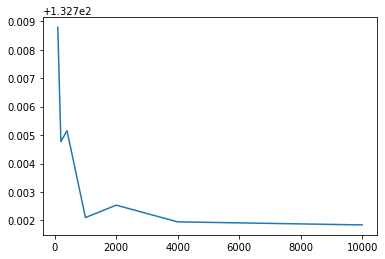

In [28]:
plt.plot(stepsPerYearList,cbPrices)